In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from matplotlib_venn import venn2
from upsetplot import plot
from upsetplot import from_memberships
import upsetplot
import matplotlib.image as mpimg

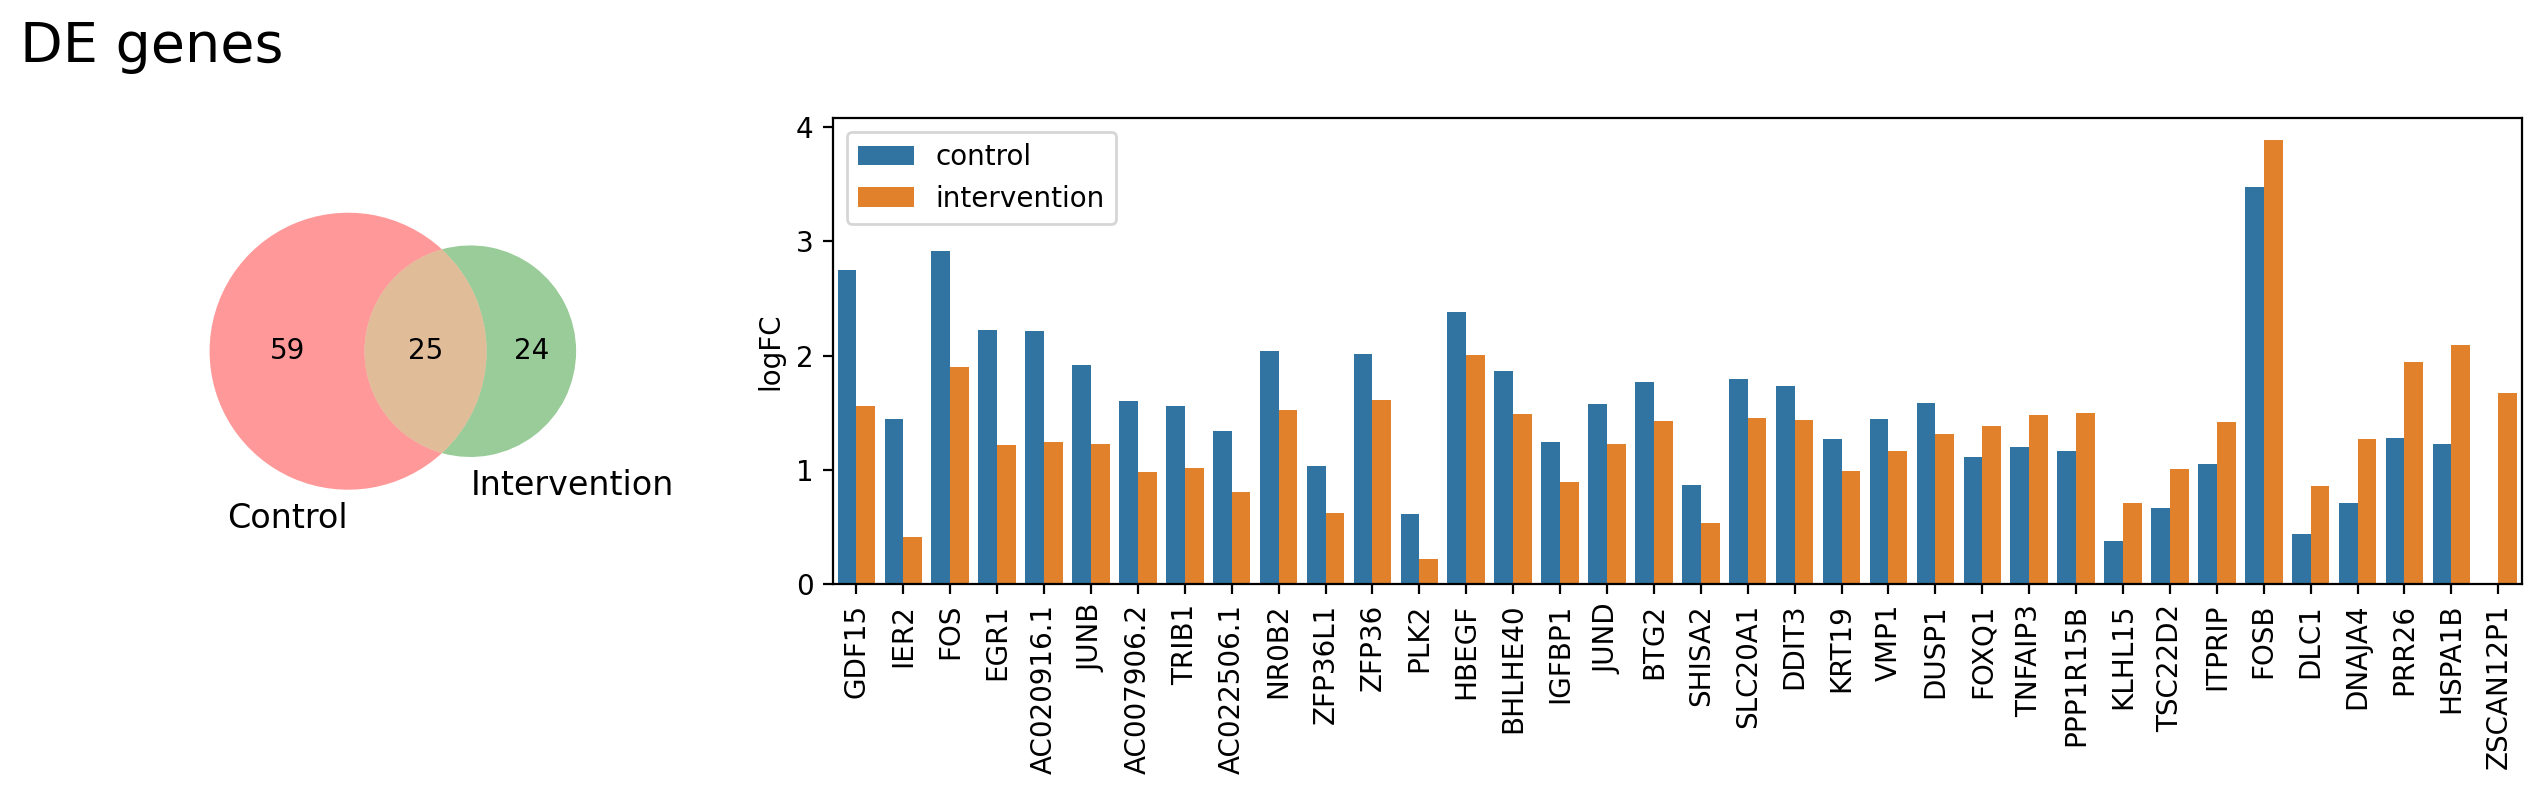

In [13]:
cn_de = pd.read_csv('results/control/ttop_de.csv')
cn_de.index = cn_de.ID
del cn_de['ID']

in_de = pd.read_csv('results/intervention/ttop_de.csv')
in_de.index = in_de.ID
del in_de['ID']

for name in list(set(in_de.index) - set(cn_de.index)):
    cn_de.loc[name] = [np.nan] * len(cn_de.columns)
    
for name in list(set(cn_de.index) - set(in_de.index)):
    in_de.loc[name] = [np.nan] * len(in_de.columns)

set_cn = set(cn_de[(cn_de['adj.P.Val'] < 0.05) & (cn_de['logFC'] > 0)].index)
set_in = set(in_de[(in_de['adj.P.Val'] < 0.05) & (in_de['logFC'] > 0)].index)
set_tl = np.array(list(set_cn | set_in))

diff = np.array(cn_de.loc[set_tl].logFC - in_de.loc[set_tl].logFC)
diff[np.isnan(diff)] = -np.nanmax(diff)
idx = np.argsort(diff)[::-1]
set_tl = set_tl[idx]
diff = diff[idx]

msk = tuple([np.abs(diff) > 0.25])
set_tl = set_tl[msk]


logFCs = np.array([list(cn_de.loc[set_tl].logFC), list(in_de.loc[set_tl].logFC)])

df = pd.DataFrame()
df['gene'] = np.hstack((set_tl, set_tl))
df['logFC'] = logFCs.flatten()
df['group'] = (['control'] * len(set_tl)) + (['intervention'] * len(set_tl))

fig, ax = plt.subplots(1,2, figsize=(12, 4), dpi=200, gridspec_kw={'width_ratios': [1, 4]})
fig.suptitle('DE genes', fontsize=20, x=0)
venn2([set_cn, set_in], ('Control', 'Intervention'), ax=ax[0])

sns.barplot(x="gene", y="logFC", hue="group", data=df, ax=ax[1])
plt.xticks(rotation=90)
ax[1].legend()
ax[1].set_xlabel('')
plt.tight_layout()
plt.show()

In [14]:
df

,gene,logFC,group
0,GDF15,2.750142,control
1,IER2,1.447780,control
2,FOS,2.909795,control
3,EGR1,2.224265,control
4,AC020916.1,2.214215,control
...,...,...,...
67,DLC1,0.858709,intervention
68,DNAJA4,1.269036,intervention
69,PRR26,1.940357,intervention
70,HSPA1B,2.094392,intervention


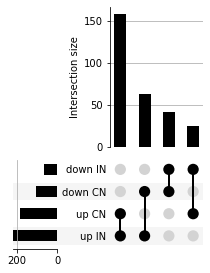

In [3]:
tf_cn = pd.read_csv('results/control/ttop_tf.csv')
tf_cn.index = tf_cn['tfs']
del tf_cn['tfs']
for _, row in tf_cn.iterrows():
    break

tf_in = pd.read_csv('results/intervention/ttop_tf.csv')
tf_in.index = tf_in['tfs']
del tf_in['tfs']

set_cn = set(tf_cn.index)
set_in = set(tf_in.index)
set_tl = np.array(list(set_cn | set_in))

m = np.array(tf_cn)
bt_msk = np.array(['BT' in col for col in tf_cn.columns])
means_bt = np.median(m[:,bt_msk], axis=1)
means_at = np.median(m[:,~bt_msk], axis=1)
cn_diff_means = means_at - means_bt

m = np.array(tf_in)
bt_msk = np.array(['BT' in col for col in tf_in.columns])
means_bt = np.median(m[:,bt_msk], axis=1)
means_at = np.median(m[:,~bt_msk], axis=1)
in_diff_means = means_at - means_bt

tf_df = pd.DataFrame()
tf_df['control'] = []
tf_df['intervention'] = []

for i, ind in enumerate(tf_cn.index):
    tf_df.loc[ind, 'control'] = cn_diff_means[i]
    
for i, ind in enumerate(tf_in.index):
    tf_df.loc[ind, 'intervention'] = in_diff_means[i]
    
tf_df['diff'] = tf_df['control'] - tf_df['intervention']

tf_df = tf_df.sort_values(by='diff', ascending=False)

cn_pos = set(tf_df.index[tf_df.control > 0])
in_pos = set(tf_df.index[tf_df.intervention > 0])
cn_neg = set(tf_df.index[tf_df.control < 0])
in_neg = set(tf_df.index[tf_df.intervention < 0])


upset_data = from_memberships(
    [
        ['up CN', 'up IN'],
        ['down CN', 'down IN'],
        ['down CN', 'up IN'],
        ['up CN', 'down IN'],
        
    ],
    data=[len(cn_pos & in_pos), len(cn_neg & in_neg), len(cn_neg & in_pos), len(cn_pos & in_neg)]
    )


tf_df = tf_df[np.abs(tf_df['diff']) > 2]


data = pd.DataFrame()
data['tf'] = list(tf_df.index) * 2
data['group'] = (['control'] * len(tf_df.index)) + (['intervention'] * len(tf_df.index))
data['diffmean'] = list(tf_df.control) + list(tf_df.intervention)

fig, ax = plt.subplots(1,1)

upsetplot.plot(upset_data, sort_by='cardinality', fig=fig)
ax.set_axis_off()
plt.savefig('tf_overlap.png', dpi=900, format='png', bbox_inches='tight')

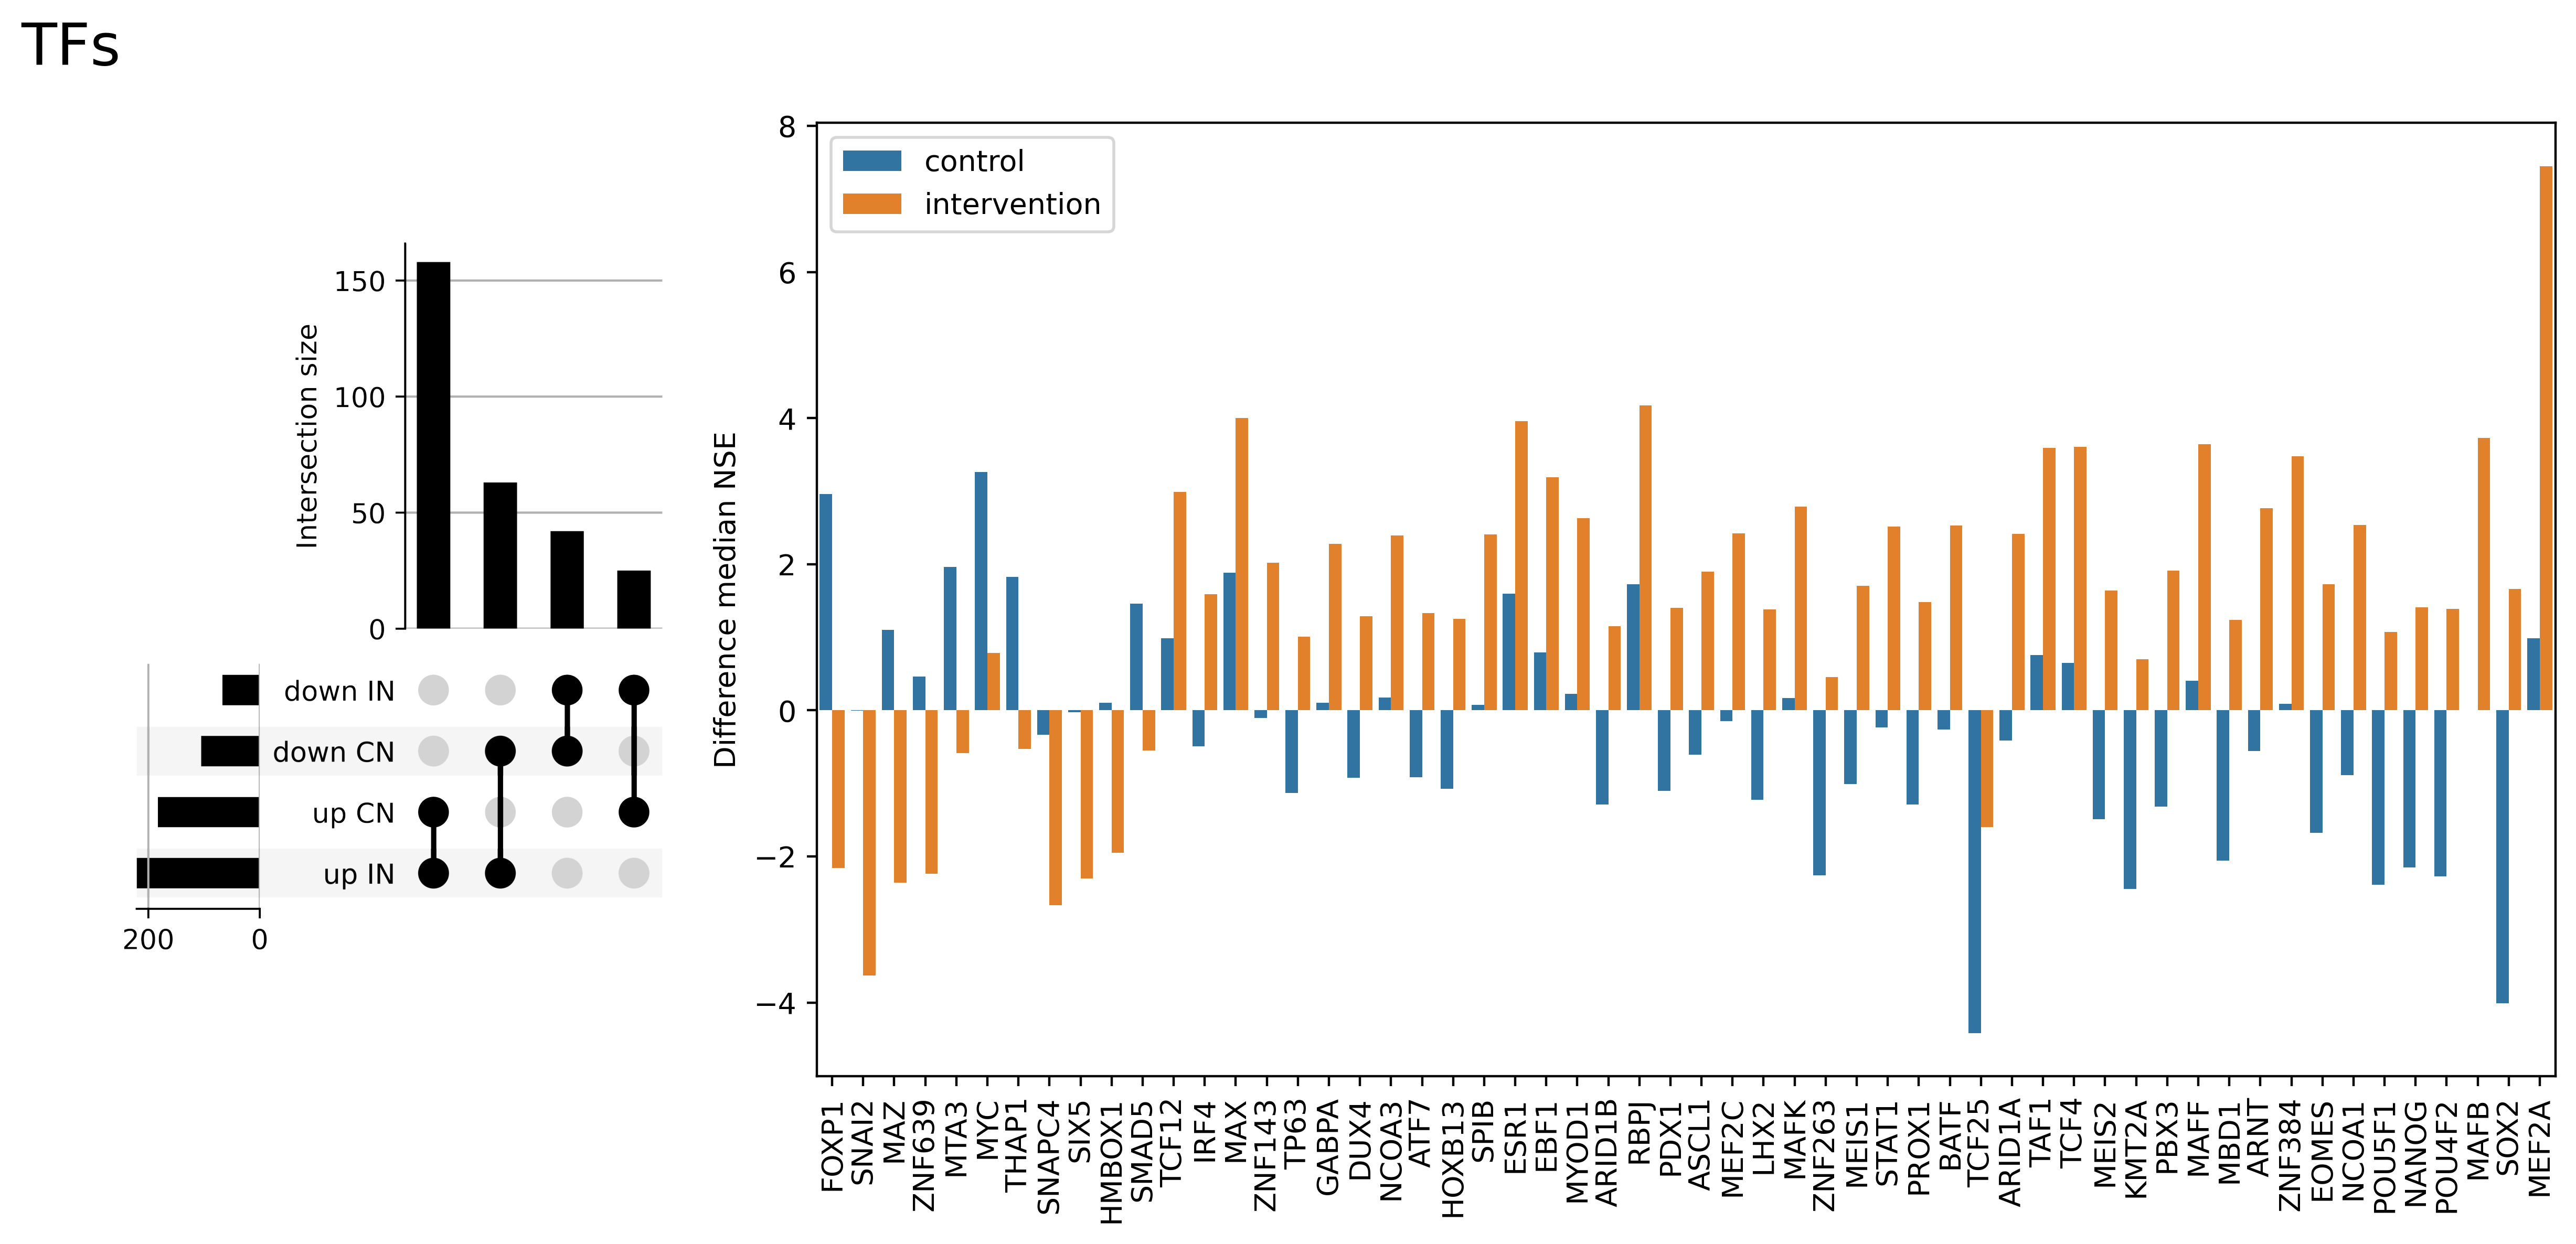

In [4]:
fig, ax = plt.subplots(1,2, figsize=(12, 6), dpi=400, gridspec_kw={'width_ratios': [1, 3]})
fig.suptitle('TFs', fontsize=20, x=0)

img = mpimg.imread('tf_overlap.png')
ax[0].imshow(img)
ax[0].axis('off')

sns.barplot(x="tf", y="diffmean", hue="group", data=data, ax=ax[1])
plt.xticks(rotation=90)
ax[1].legend()
ax[1].set_xlabel('')
ax[1].set_ylabel('Difference median NSE')
plt.tight_layout()
plt.show()

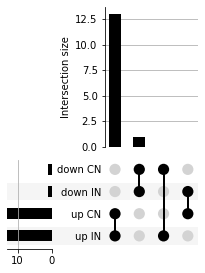

In [5]:
tf_cn = pd.read_csv('results/control/ttop_pw.csv')
tf_cn.index = tf_cn['pathway']
del tf_cn['pathway']
for _, row in tf_cn.iterrows():
    break

tf_in = pd.read_csv('results/intervention/ttop_pw.csv')
tf_in.index = tf_in['pathway']
del tf_in['pathway']

set_cn = set(tf_cn.index)
set_in = set(tf_in.index)
set_tl = np.array(list(set_cn | set_in))

m = np.array(tf_cn)
bt_msk = np.array(['BT' in col for col in tf_cn.columns])
means_bt = np.median(m[:,bt_msk], axis=1)
means_at = np.median(m[:,~bt_msk], axis=1)
cn_diff_means = means_at - means_bt

m = np.array(tf_in)
bt_msk = np.array(['BT' in col for col in tf_in.columns])
means_bt = np.median(m[:,bt_msk], axis=1)
means_at = np.median(m[:,~bt_msk], axis=1)
in_diff_means = means_at - means_bt

tf_df = pd.DataFrame()
tf_df['control'] = []
tf_df['intervention'] = []

for i, ind in enumerate(tf_cn.index):
    tf_df.loc[ind, 'control'] = cn_diff_means[i]
    
for i, ind in enumerate(tf_in.index):
    tf_df.loc[ind, 'intervention'] = in_diff_means[i]
    
tf_df['diff'] = tf_df['control'] - tf_df['intervention']

tf_df = tf_df.sort_values(by='diff', ascending=False)

cn_pos = set(tf_df.index[tf_df.control > 0])
in_pos = set(tf_df.index[tf_df.intervention > 0])
cn_neg = set(tf_df.index[tf_df.control < 0])
in_neg = set(tf_df.index[tf_df.intervention < 0])


upset_data = from_memberships(
    [
        ['up CN', 'up IN'],
        ['down CN', 'down IN'],
        ['down CN', 'up IN'],
        ['up CN', 'down IN'],
        
    ],
    data=[len(cn_pos & in_pos), len(cn_neg & in_neg), len(cn_neg & in_pos), len(cn_pos & in_neg)]
    )


data = pd.DataFrame()
data['tf'] = list(tf_df.index) * 2
data['group'] = (['control'] * len(tf_df.index)) + (['intervention'] * len(tf_df.index))
data['diffmean'] = list(tf_df.control) + list(tf_df.intervention)

fig, ax = plt.subplots(1,1)

upsetplot.plot(upset_data, sort_by='cardinality', fig=fig)
ax.set_axis_off()
plt.savefig('pw_overlap.png', dpi=900, format='png', bbox_inches='tight')

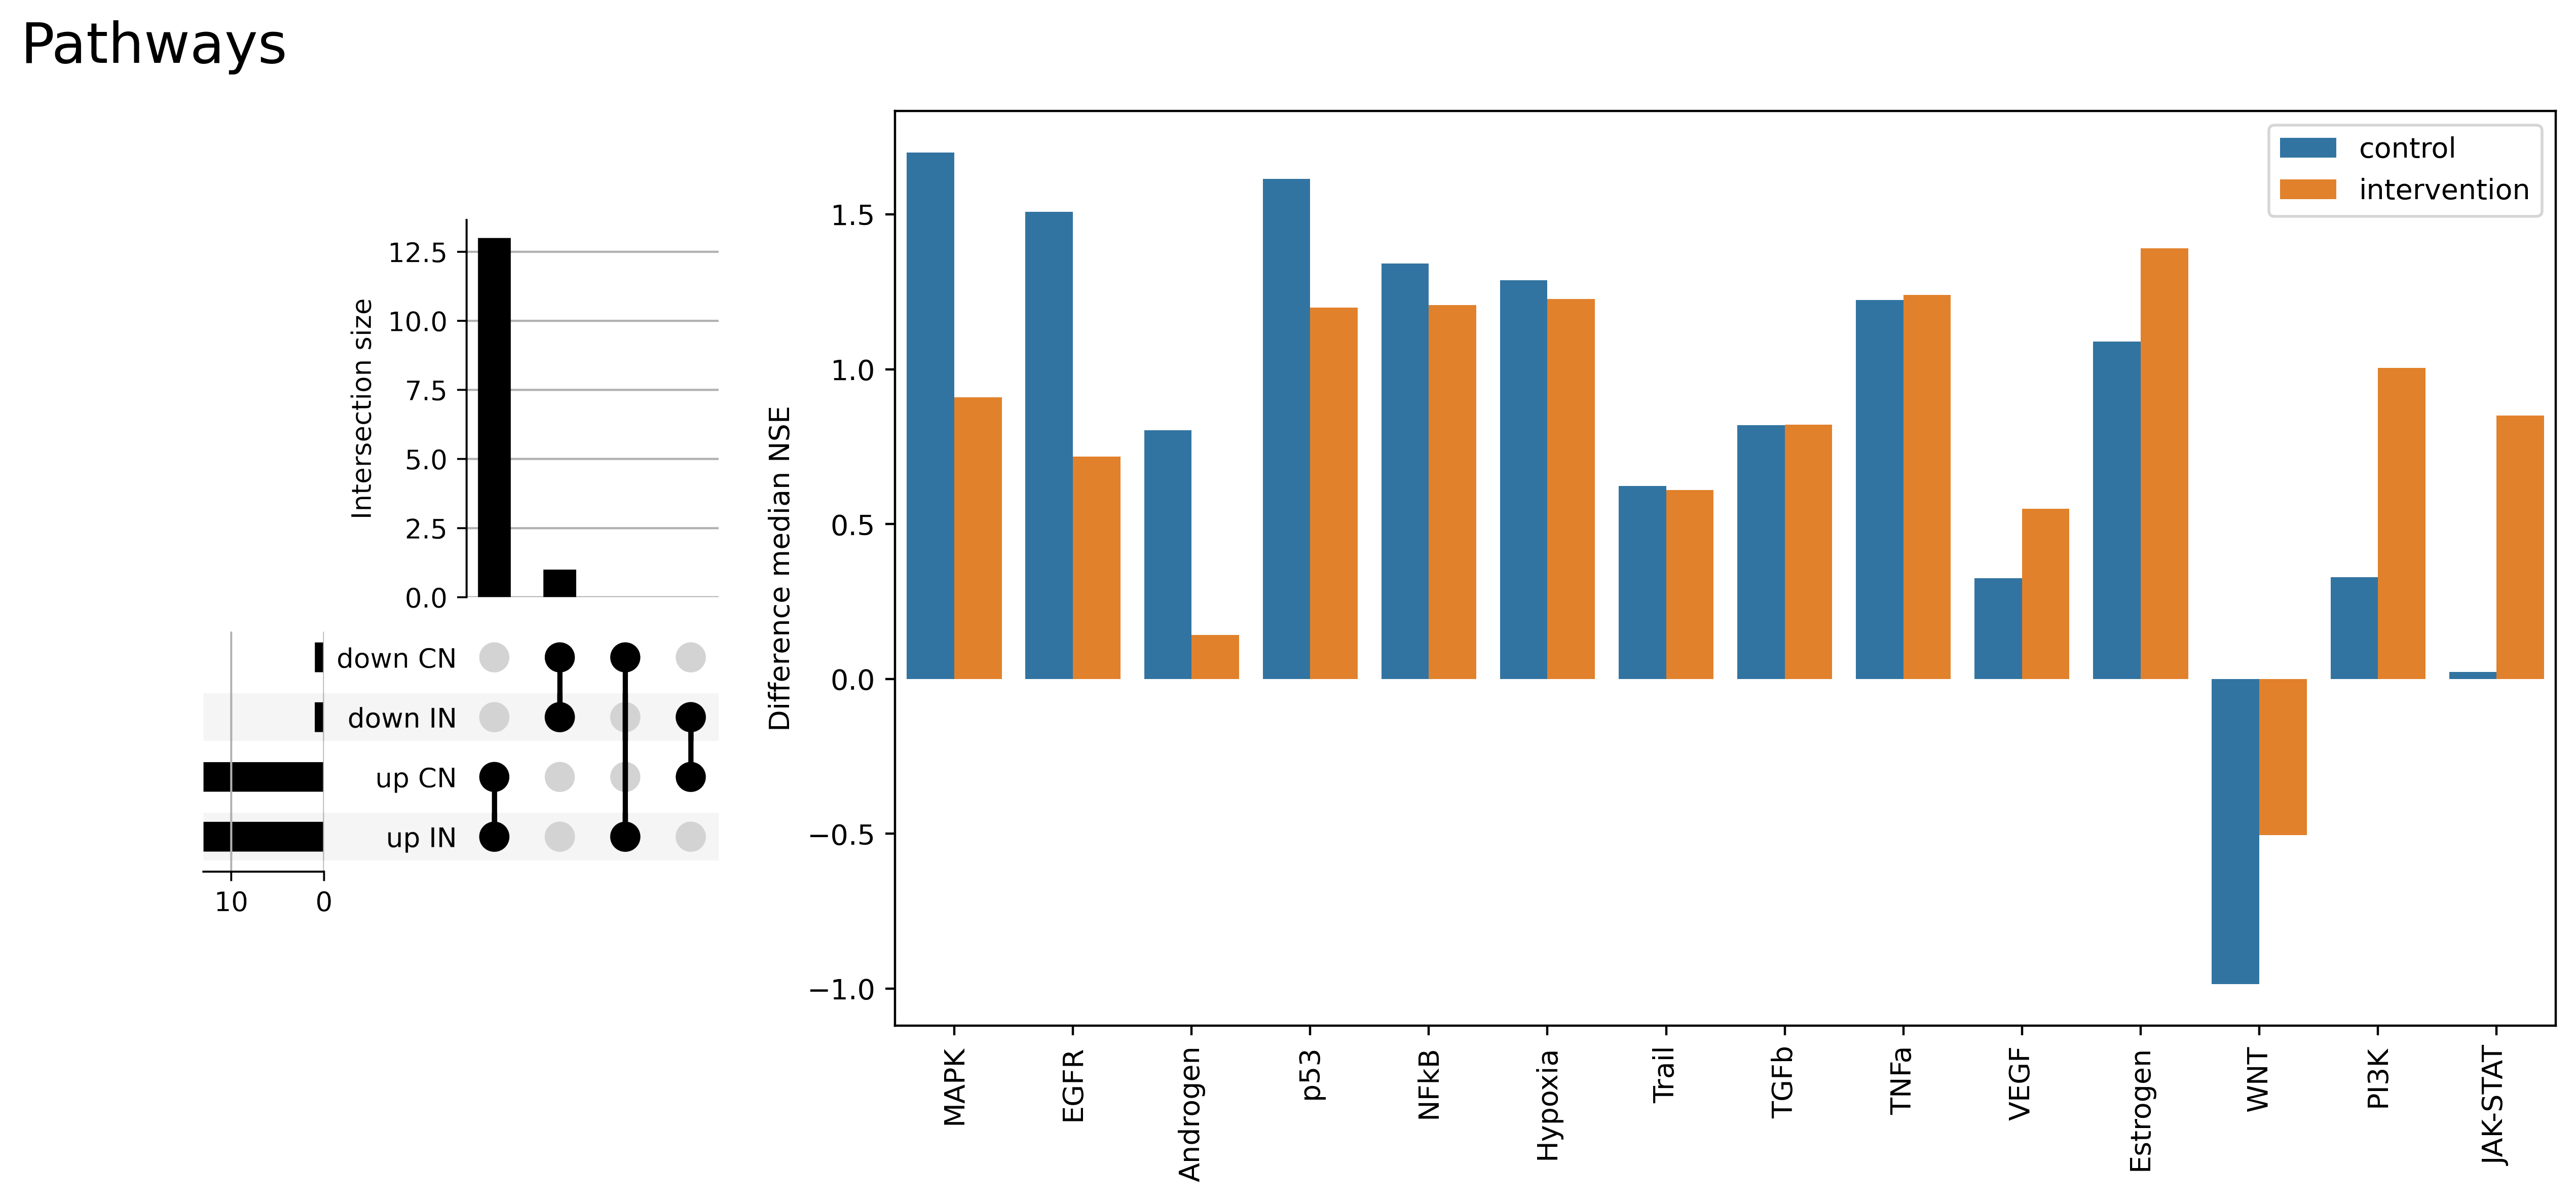

In [6]:
fig, ax = plt.subplots(1,2, figsize=(12, 6), dpi=400, gridspec_kw={'width_ratios': [1, 3]})
fig.suptitle('Pathways', fontsize=20, x=0)

img = mpimg.imread('pw_overlap.png')
ax[0].imshow(img)
ax[0].axis('off')

sns.barplot(x="tf", y="diffmean", hue="group", data=data, ax=ax[1])
plt.xticks(rotation=90)
ax[1].legend()
ax[1].set_xlabel('')
ax[1].set_ylabel('Difference median NSE')
plt.tight_layout()
plt.show()